In [3]:
#All import statements here
import sys
import os
import pickle
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from ast import literal_eval

import matplotlib.pyplot as plt

import nltk
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import map_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('always')

# Load NLTK's English stop-words list
stop_words = set(stopwords.words('english'))

print("Loading already processed training data")
data_df = pd.read_excel("/Users/pragya/Desktop/Grad SemB/Not All bugs are the same/dataset+additional_analysis.xlsx", sheet_name="Dataset - Bug Report")                       #/Users/pragya/Desktop/Not All bugs are the same/dataset.csv
data_df.head(5)   
data_df['Classification'].unique()

Loading already processed training data


array(['Add issue', 'Configuration issue', 'Database-related issue',
       'Functional issue', 'GUI-related issue', 'info release issue',
       'Network issue', 'Performance issue',
       'Permission/Deprecation issue', 'Security issue',
       'Test Code-related issue'], dtype=object)

In [5]:
data_df["Classification"] = data_df["Classification"].apply(
    lambda x: [x]
)
print(data_df["Classification"].values[:5])

#Splitting data using Stratified splitting function
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    data_df,
    test_size=test_split,
    stratify=data_df["Classification"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")


[list(['Add issue']) list(['Add issue']) list(['Add issue'])
 list(['Add issue']) list(['Add issue'])]
Number of rows in training set: 1152
Number of rows in validation set: 64
Number of rows in test set: 64


In [6]:
terms = tf.ragged.constant(train_df["Classification"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

2023-03-25 10:35:01.637532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Vocabulary:

['[UNK]', 'Functional issue', 'GUI-related issue', 'Configuration issue', 'Add issue', 'Test Code-related issue', 'Security issue', 'Network issue', 'Performance issue', 'Permission/Deprecation issue', 'Database-related issue', 'info release issue']


In [7]:
sample_label = train_df["Classification"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Test Code-related issue']
Label-binarized representation: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [8]:
train_df["Summary"].apply(lambda x: len(x.split(" "))).describe()

count    1152.000000
mean        8.086806
std         3.541405
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        26.000000
Name: Summary, dtype: float64

In [9]:
max_seqlen = 8
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["Classification"].values)
    print(labels.shape)
    label_binarized = lookup(labels).numpy()
    print(label_binarized.shape)
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Summary"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [10]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

(1152, None)
(1152, 12)
(64, None)
(64, 12)
(64, None)
(64, 12)


In [11]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Release Bugzilla 5.0rc1, 4.4.7, 4.2.12, and 4.0.16'
Label(s): ['info release issue']
 
Abstract: b'Adobe Acrobat claims Fop output has bad page contents'
Label(s): ['GUI-related issue']
 
Abstract: b'Auto translate feature "View Original" shows a blank page'
Label(s): ['GUI-related issue']
 
Abstract: b'Menu accesskey (shortcut key) info should be in DTD.'
Label(s): ['GUI-related issue']
 
Abstract: b'mod_rewrite; RewriteLock permissions failure'
Label(s): ['Permission/Deprecation issue']
 


In [12]:
vocabulary = set()
train_df["Summary"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

3350


In [13]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [14]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/9
9/9 [==============================] - 1s 25ms/step - loss: 0.3922 - accuracy: 0.2656 - val_loss: 0.3267 - val_accuracy: 0.3125
Epoch 2/9
9/9 [==============================] - 0s 15ms/step - loss: 0.2293 - accuracy: 0.5521 - val_loss: 0.2948 - val_accuracy: 0.3281
Epoch 3/9
9/9 [==============================] - 0s 15ms/step - loss: 0.1666 - accuracy: 0.6823 - val_loss: 0.2434 - val_accuracy: 0.3906
Epoch 4/9
9/9 [==============================] - 0s 16ms/step - loss: 0.1107 - accuracy: 0.8472 - val_loss: 0.2367 - val_accuracy: 0.4688
Epoch 5/9
9/9 [==============================] - 0s 15ms/step - loss: 0.0695 - accuracy: 0.9149 - val_loss: 0.2332 - val_accuracy: 0.5000
Epoch 6/9
9/9 [==============================] - 0s 15ms/step - loss: 0.0415 - accuracy: 0.9601 - val_loss: 0.2596 - val_accuracy: 0.4844
Epoch 7/9
9/9 [==============================] - 0s 15ms/step - loss: 0.0254 - accuracy: 0.9757 - val_loss: 0.2780 - val_accuracy: 0.4844
Epoch 8/9
9/9 [===================

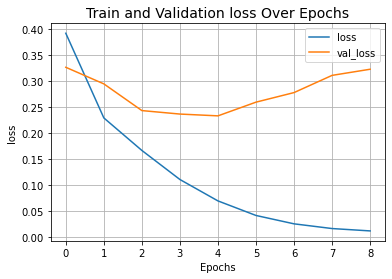

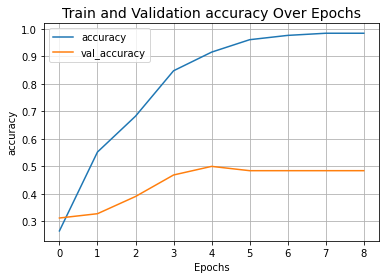

In [15]:
epochs = 9

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
#tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),

# metrics"binary_accuracy"
history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
#plot_result("precision_15")
#plot_result("recall_8")
plot_result("accuracy")

In [16]:
_, acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(acc * 100, 2)}%.")

1/1 [==============================] - 0s 83ms/step - loss: 0.2849 - accuracy: 0.5625
Categorical accuracy on the test set: 56.25%.


In [18]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(64), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

predicted_classes=np.argmax(model_for_inference.predict(text_batch),axis=1) 

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Summary: {text}")
    print(f"Classification: {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Classification: ({', '.join([label for label in top_3_labels])})")
    print(" ")

(64, None)
(64, 12)
2/2 [==============================] - 0s 4ms/step
Summary: b'Translate svn-ref.tex to French'
Classification: ['Add issue']
Predicted Classification: (Functional issue, GUI-related issue, Configuration issue)
 
Summary: b'Unable to login on a fresh Bugzilla install using the login form on the home page'
Classification: ['Security issue']
Predicted Classification: (Add issue, GUI-related issue, Functional issue)
 
Summary: b'Remove #ifndef NECKO from tree'
Classification: ['Configuration issue']
Predicted Classification: (Configuration issue, Functional issue, Test Code-related issue)
 
Summary: b'NLS33:plugins referenced by org.eclipse.wst.rdb_userdoc.feature is missing'
Classification: ['Configuration issue']
Predicted Classification: (Configuration issue, Functional issue, GUI-related issue)
 
Summary: b'Java launch debug session aborts after 10 seconds'
Classification: ['Functional issue']
Predicted Classification: (Add issue, Functional issue, Configuration iss